In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import datasets
from torchvision import transforms
from PIL import Image, ImageFilter, ImageEnhance
import PIL.ImageOps


In [2]:
class ANN(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        super(ANN, self).__init__()
        self.dropout = nn.Dropout(p=0.2)  #https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,output_size)
    def forward(self, input):
        input = input.reshape(-1,self.input_size) #flatten
        output = self.fc1(input)
        output = self.dropout(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output

In [3]:
input_size = 28*28
hidden_size = 25
output_size = 10
torch.manual_seed(3407)
ann = ANN(input_size, output_size,hidden_size)
optimizer = torch.optim.Adam(ann.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
ann.to(device)

cuda:0


ANN(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=25, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)

In [5]:
mnist_train = datasets.MNIST('./', download=True,transform = transforms.ToTensor())
mnist_test = datasets.MNIST('./', download=True, train=False,transform = transforms.ToTensor())


tensor([7, 2, 1,  ..., 4, 5, 6])


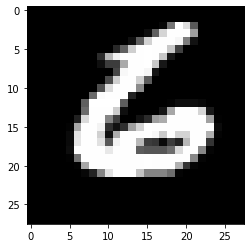

In [6]:
#show sample image of MNIST
label =  mnist_test.targets
image = mnist_test.data[-1, :, :].numpy()
plt.imshow(image,cmap = "gray")
print(label)

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

num_epochs: 0
num_epochs: 1
num_epochs: 2
num_epochs: 3
num_epochs: 4
num_epochs: 5
num_epochs: 6
num_epochs: 7
num_epochs: 8
num_epochs: 9
num_epochs: 10
num_epochs: 11
num_epochs: 12
num_epochs: 13
num_epochs: 14
num_epochs: 15
num_epochs: 16
num_epochs: 17
num_epochs: 18
num_epochs: 19


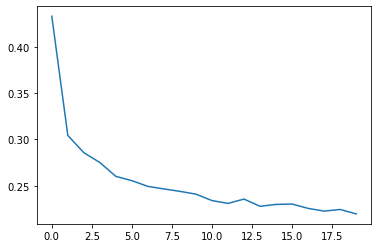

In [8]:
ann.train()
num_epochs = 20
losses = []
accuracy = []
for i in range(num_epochs):
    print(f"num_epochs: {i}")
    avg_losses = []
    for index , (img , label) in enumerate(train_loader):
        img , label = img.to(device) , label.to(device)
        optimizer.zero_grad()
        output = ann.forward(img)
        loss = criterion(output,label)
        avg_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    losses.append(np.mean(avg_losses))
plt.plot(losses)

In [9]:
ann.eval()
accuracy = []
for index , (img , label) in enumerate(test_loader):
    img, label = img.to(device) , label.to(device)
    output = ann.forward(img)
    _ , max_indices = torch.max(output,1)
    test_acc = np.mean(np.round(label.detach().cpu().numpy()) == np.round(max_indices.detach().cpu().numpy()))
    accuracy.append(test_acc)
np.mean(accuracy)



0.9533227848101266

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 959    1    4    0    0    3    8    3    2    0]
 [   0 1113    7    3    0    0    1    1   10    0]
 [   4    2  991    1    4    0    7   16    7    0]
 [   3    0   13  947    2   22    0   11    5    7]
 [   1    0    3    1  938    1   15    4    1   18]
 [   4    0    2    6    4  828   23    4   14    7]
 [   8    2    2    0    3    3  939    0    1    0]
 [   2    4   12    7    2    0    1  992    0    8]
 [  15    5    7    4    9    4   16   19  889    6]
 [   4    5    2   11   26    6    2   17    4  932]]


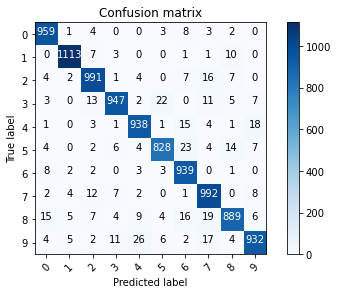

In [11]:
x_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = ann(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

(28, 28)
(28, 28)
torch.Size([1, 784])
tensor([[-25.4058,  -1.4932,   1.5472,  14.8387, -12.2928,  14.6851, -47.5024,
         -16.5590,  -0.8827,   1.2769]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
image prediction: 3


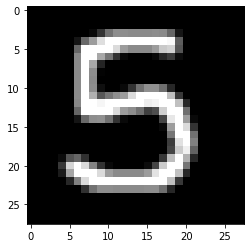

In [16]:
image = PIL.ImageOps.invert(Image.open(r"./5.png")).convert('L')

#image processing for to make it look like MNIST images
image = image.filter(ImageFilter.GaussianBlur(radius = 1))
enhancer = ImageEnhance.Contrast(image)
factor = 3
im_output = enhancer.enhance(factor)

print(image.size)
eigth = np.array(im_output)
plt.imshow(eigth,cmap = "gray")
print(eigth.shape)
eigth = eigth/255
eigth = torch.tensor(eigth,dtype=torch.float32)
eigth = eigth.reshape(1,-1)
print(eigth.size())
eigth = eigth.to(device)
pred = ann(eigth)
print(pred)
_, predictions = torch.max(pred, 1)
print(f"image prediction: {predictions.item()}")